In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib as mpl
from matplotlib import rc
rc('figure', figsize=(19,10))
from colorsys import hls_to_rgb

In [2]:
def colorize(
    z,
    theme="dark",
    saturation=1.0,
    beta=1.4,
    transparent=False,
    alpha=1.0,
    max_threshold=1,
):
    r = np.abs(z)
    r /= max_threshold * np.max(np.abs(r))
    arg = np.angle(z)

    h = (arg + np.pi) / (2 * np.pi) + 0.5
    l = 1.0 / (1.0 + r**beta) if theme == "white" else 1.0 - 1.0 / (1.0 + r**beta)
    s = saturation

    c = np.vectorize(hls_to_rgb)(h, l, s)  # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0, 2)
    if transparent:
        a = 1.0 - np.sum(c**2, axis=-1) / 3
        alpha_channel = a[..., None] ** alpha
        return np.concatenate([c, alpha_channel], axis=-1)
    else:
        return c

## I. Parameters

In [3]:
## Parameters of the DMD
d = 7.6 # pitch in microns
theta = 12./180*np.pi
theta_1D = np.arctan(np.tan(theta)/np.sqrt(2))
## Wavelength
_lambda = 0.633 # in microns
## Incident angle
alpha = 10./180*np.pi
alpha_1D = np.arctan(np.tan(alpha)/np.sqrt(2))

## II. Modulation efficiency

### II.1 Computation of the *blazed number* $\mu$

In [4]:
## A simple criterion matching the diffraction angle and the reflection angle
def get_p(d, theta, _lambda):
    theta_1D = np.arctan(np.tan(theta)/np.sqrt(2))
    _beta = lambda alpha: 2*theta_1D-alpha
    return lambda alpha: 1.*d/_lambda *(np.sin(alpha)+np.sin(_beta(alpha)))
    # or
    # return lambda alpha: 2.*d/_lambda *np.sin(theta_1D)*np.cos(theta_1D-alpha)

p = get_p(d, theta, _lambda)
# when p is an integer, we are at a blazing angle with a maximum of energy at the order along the optical axis
# whem p is n+1/2, the enregy is spread over many diffraction orders not aligned with the optical axis

In [5]:
# test different incident angles
alpha_vec = np.linspace(-np.pi/2,np.pi/2,1000)
alpha_1D_vec = np.arctan(np.tan(alpha_vec)/np.sqrt(2))
# criterion = np.abs(np.mod([mu(a) for a in alpha_1D_vec],1)-0.5)
def get_mu(d, theta, _lambda):
    p = get_p(d, theta, _lambda)
    return lambda alpha: np.abs(np.mod(2*p(alpha),2)-1)

f_mu = get_mu(d, theta, _lambda)
criterion = np.fromiter((f_mu(a) for a in alpha_1D_vec), float)
#np.abs(np.mod([2*p(a) for a in alpha_1D_vec],2)-1)
alpha1 = 0
alpha2 = 20./180*np.pi

### II.2 Dependence of $\mu$ with the pixel pitch and incident angle $\alpha$



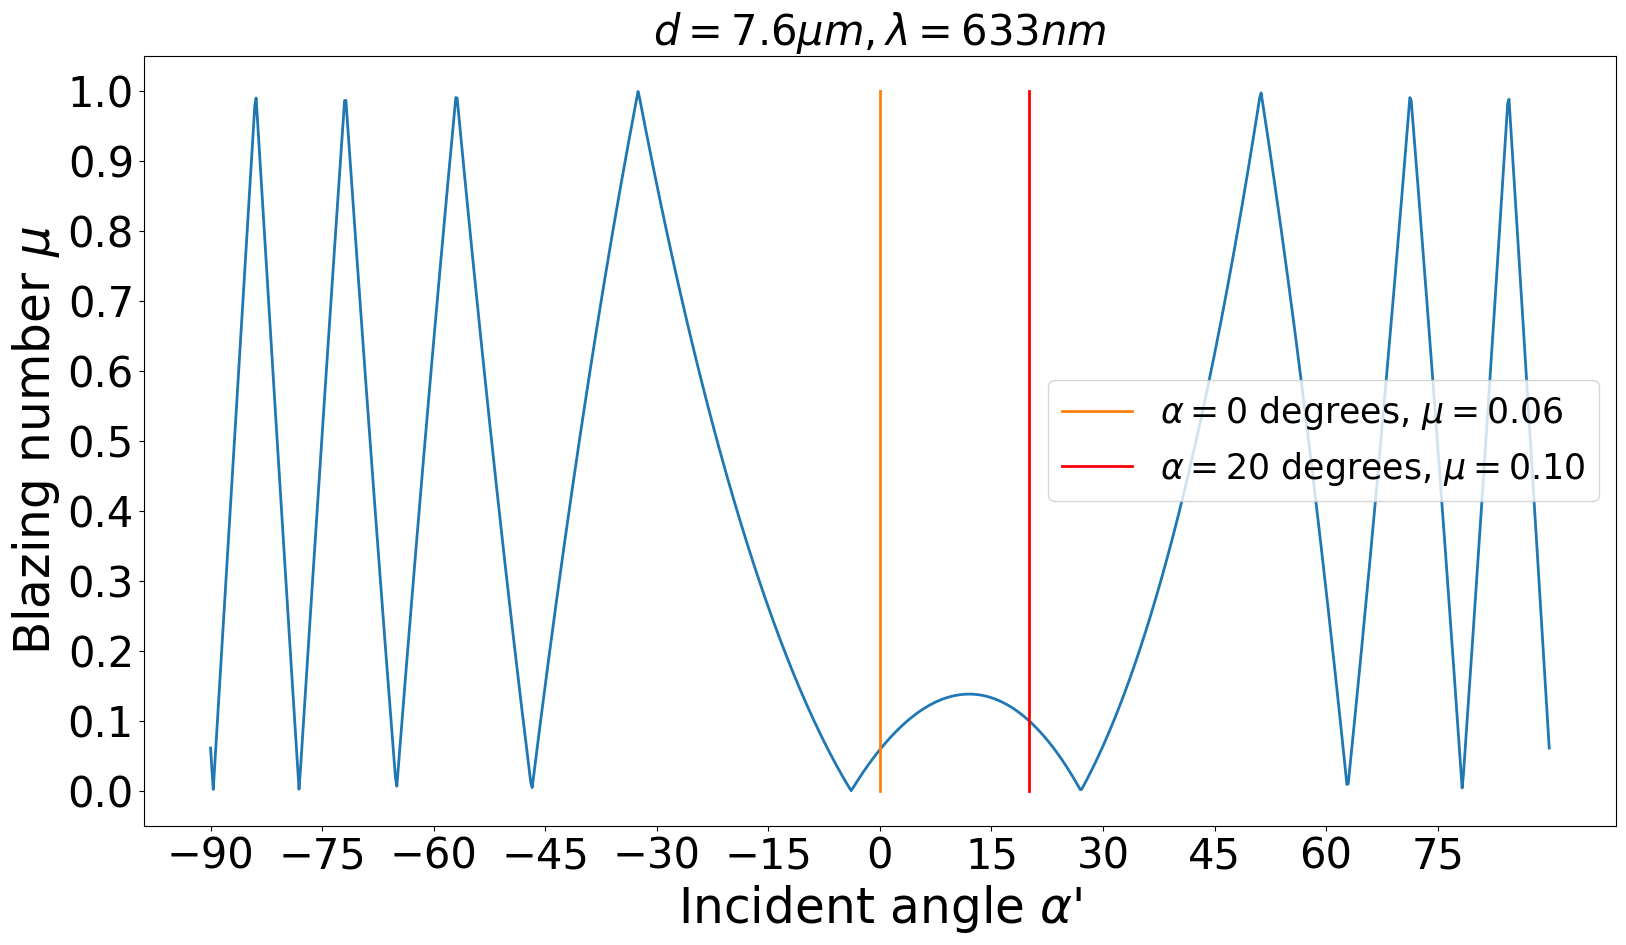

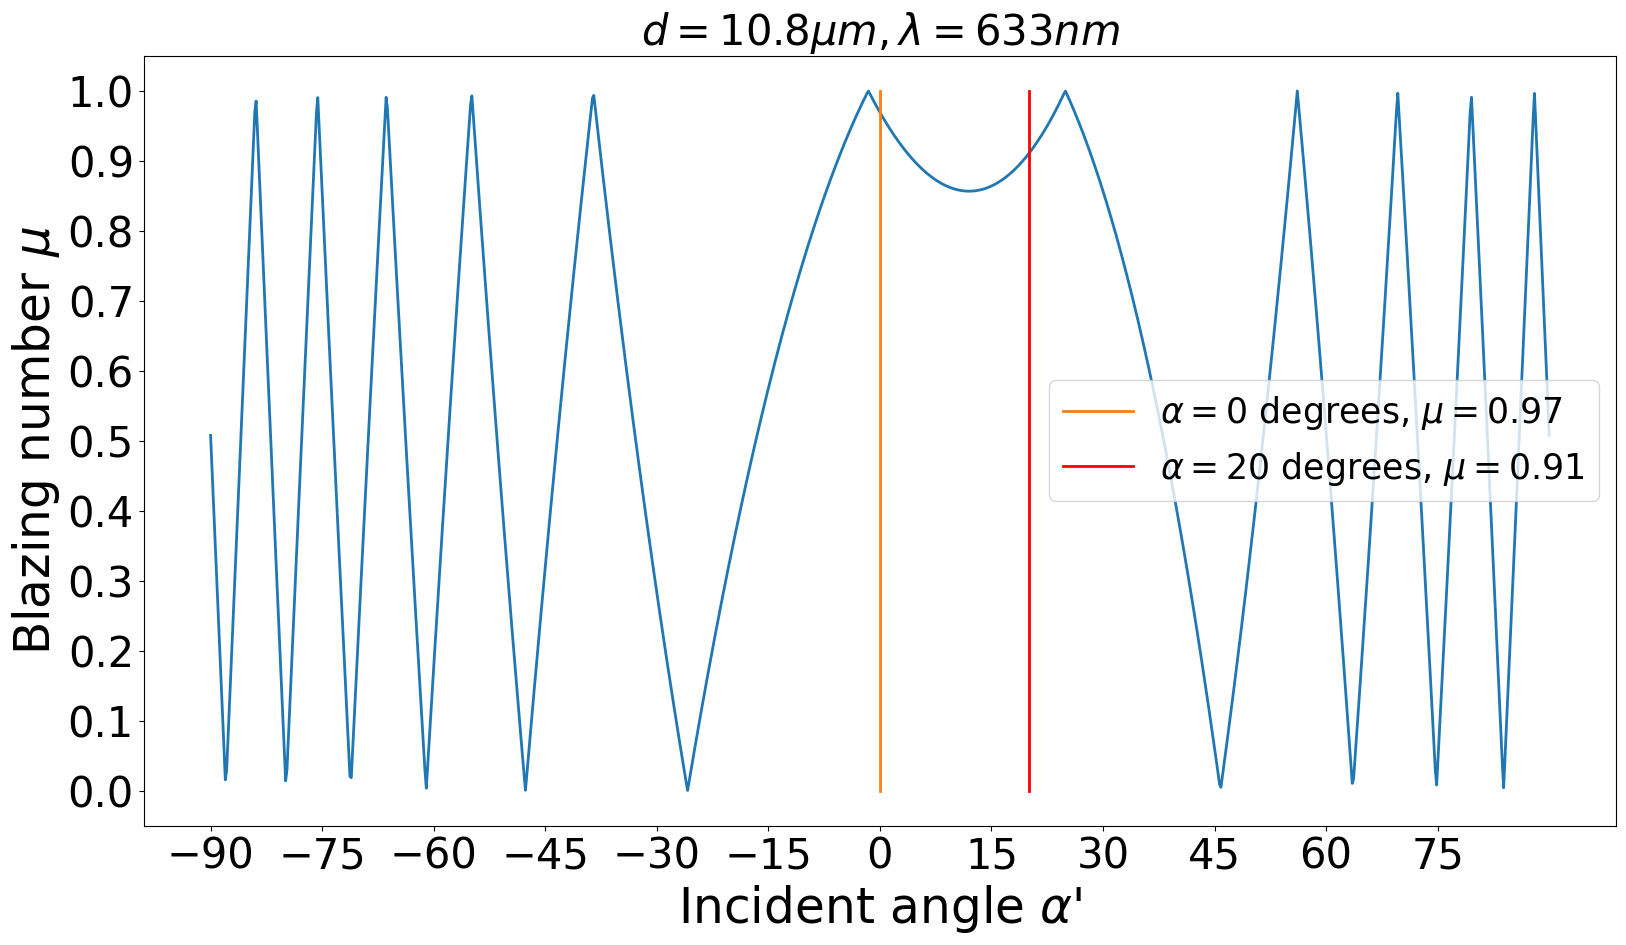

In [6]:

def show_mu(d, theta, _lambda, alphas):
    max_val = 1

    f_mu = get_mu(d, theta, _lambda)
    
    alpha_vec = np.linspace(-np.pi/2,np.pi/2,1000)
    alpha_1D_vec = np.arctan(np.tan(alpha_vec)/np.sqrt(2))

    criterion = np.fromiter((f_mu(a) for a in alpha_1D_vec), float)

    plt.figure()
    plt.plot(alpha_vec*180/np.pi,criterion,linewidth = 2)

    def get_label(alpha):
        alpha_1D = np.arctan(np.tan(alpha)/np.sqrt(2))
        label =  rf'$\alpha = {alpha*180/np.pi:.0f}$ degrees, $\mu = {f_mu(alpha_1D):.2f}$'
        return label
    plt.plot([alphas[0]*180/np.pi]*2,[0.,max_val],label = get_label(alphas[0]), linewidth = 2)
    plt.plot([alphas[1]*180/np.pi]*2,[0.,max_val],label = get_label(alphas[1]), color = 'red',linewidth = 2)
    # plt.plot([0,0],[0.,max_val],color = 'red',linewidth = 2)
    plt.xticks(np.arange(-90,90,15),fontsize = 30)
    plt.yticks(np.arange(0,max_val+0.05,0.1),fontsize = 30)
    plt.title(r'$d=%.1f\mu m, \lambda =%g nm$' % (d,1e3*_lambda),fontsize = 30)
    plt.legend(fontsize = 25,loc='center right')
    plt.ylabel(r'Blazing number $\mu$', fontsize = 35)
    plt.xlabel(r"Incident angle $\alpha$'", fontsize = 35)
    image_prefix = f'blazing_angle_d{d:.1f}_theta{theta:.1f}_lambda{_lambda:.1f}_alpha{alpha:.1f}'
    plt.savefig(image_prefix+'_mu.svg', dpi = 300)

show_mu(d, theta, _lambda, alphas = [alpha1,alpha2])
d2 = 10.8
show_mu(d2, theta, _lambda, alphas = [alpha1,alpha2])

### II.3 Dependence of $\mu$ with the wavelength $\lambda$

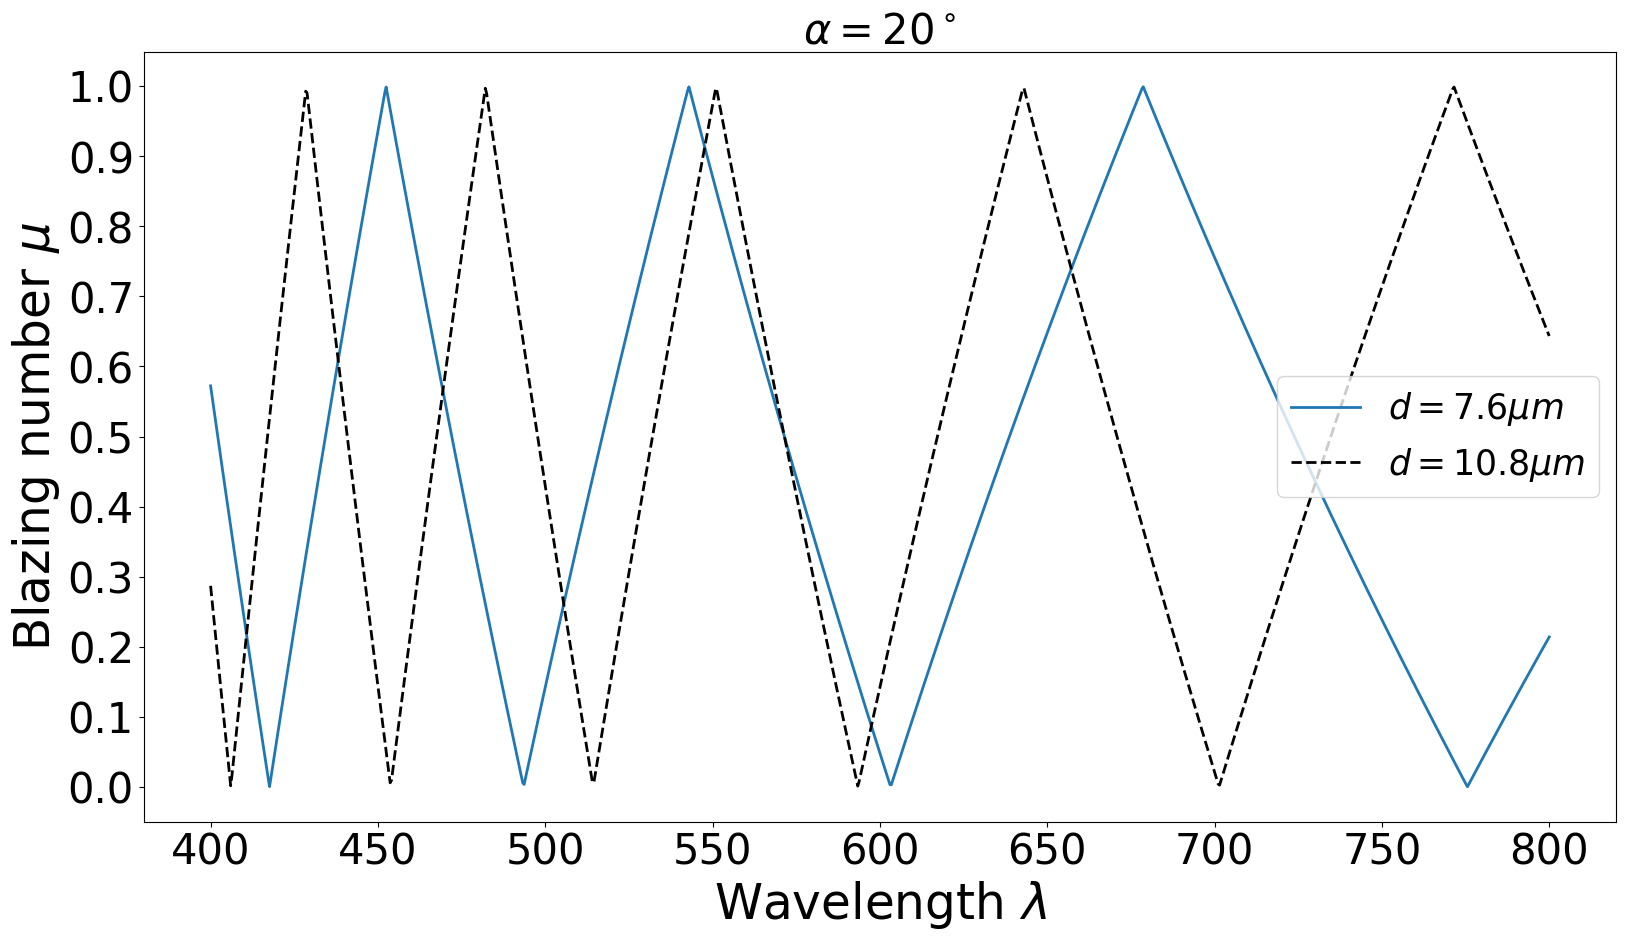

In [7]:
def get_mu_vs_lambda(d, theta, _lambda):
    def f_mu(_lambda):
        p = get_p(d, theta, _lambda)
        return get_mu(d, theta, _lambda)(alpha_1D)  
    return f_mu

_lambda_vec = np.linspace(.4,.8,1000)
alpha = 20
alpha_1D = np.arctan(np.tan(alpha*np.pi/180)/np.sqrt(2))
max_val = 1

f_mu = get_mu_vs_lambda(d, alpha_1D, _lambda)
f_mu2 = get_mu_vs_lambda(d2, alpha_1D, _lambda)




criterion_lambda_d = np.fromiter((f_mu(_lambda) for _lambda in _lambda_vec), float)
criterion_lambda_d2 = np.fromiter((f_mu2(_lambda) for _lambda in _lambda_vec), float)

plt.figure()
plt.plot(_lambda_vec*1e3,criterion_lambda_d,linewidth = 2, label = rf'$d = {d:.1f}\mu m$')
plt.plot(_lambda_vec*1e3,criterion_lambda_d2,'k--', linewidth = 2, label = rf'$d = {d2:.1f}\mu m$')


plt.xticks(fontsize = 30)
plt.yticks(np.arange(0,max_val+0.05,0.1),fontsize = 30)
plt.title(r'$\alpha =' + str(alpha) + '^\circ$' ,fontsize = 30)

plt.ylabel(r'Blazing number $\mu$', fontsize = 35)
plt.xlabel(r'Wavelength $\lambda$', fontsize = 35)
plt.legend(fontsize = 25,loc='center right')
image_prefix = f'blazing_angle_d{d:.1f}_alpha{_lambda:.1f}_alpha{alpha:.1f}'
plt.savefig(image_prefix+'_mu.svg', dpi = 300)

### II.4 Dependence of $\mu$ with the wavelength and the incident angle $\alpha$

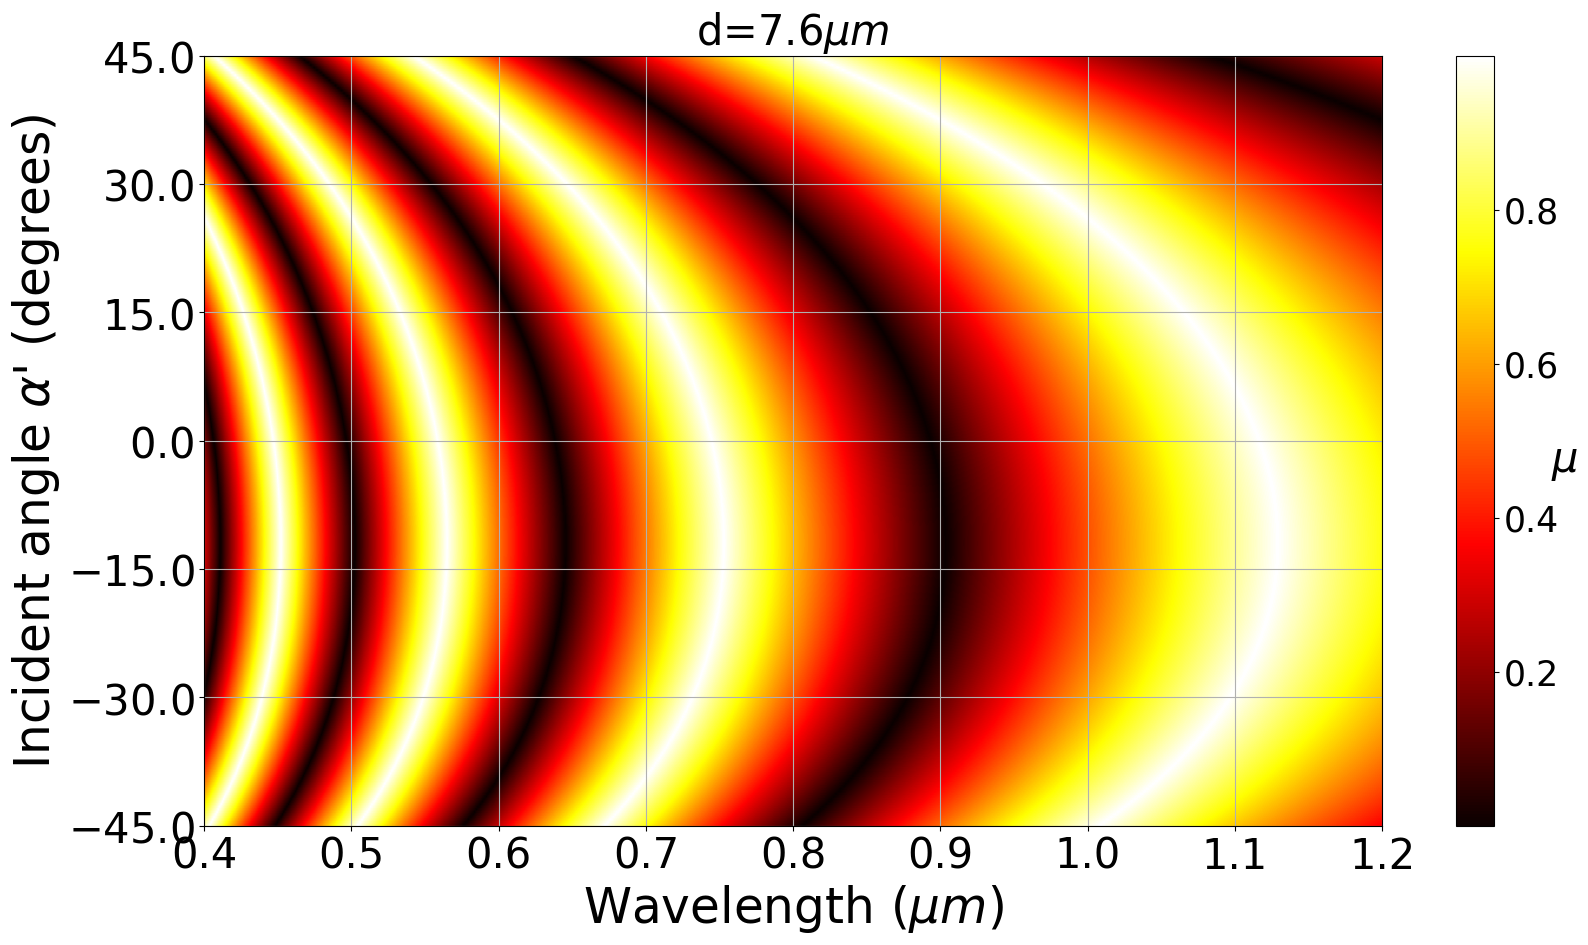

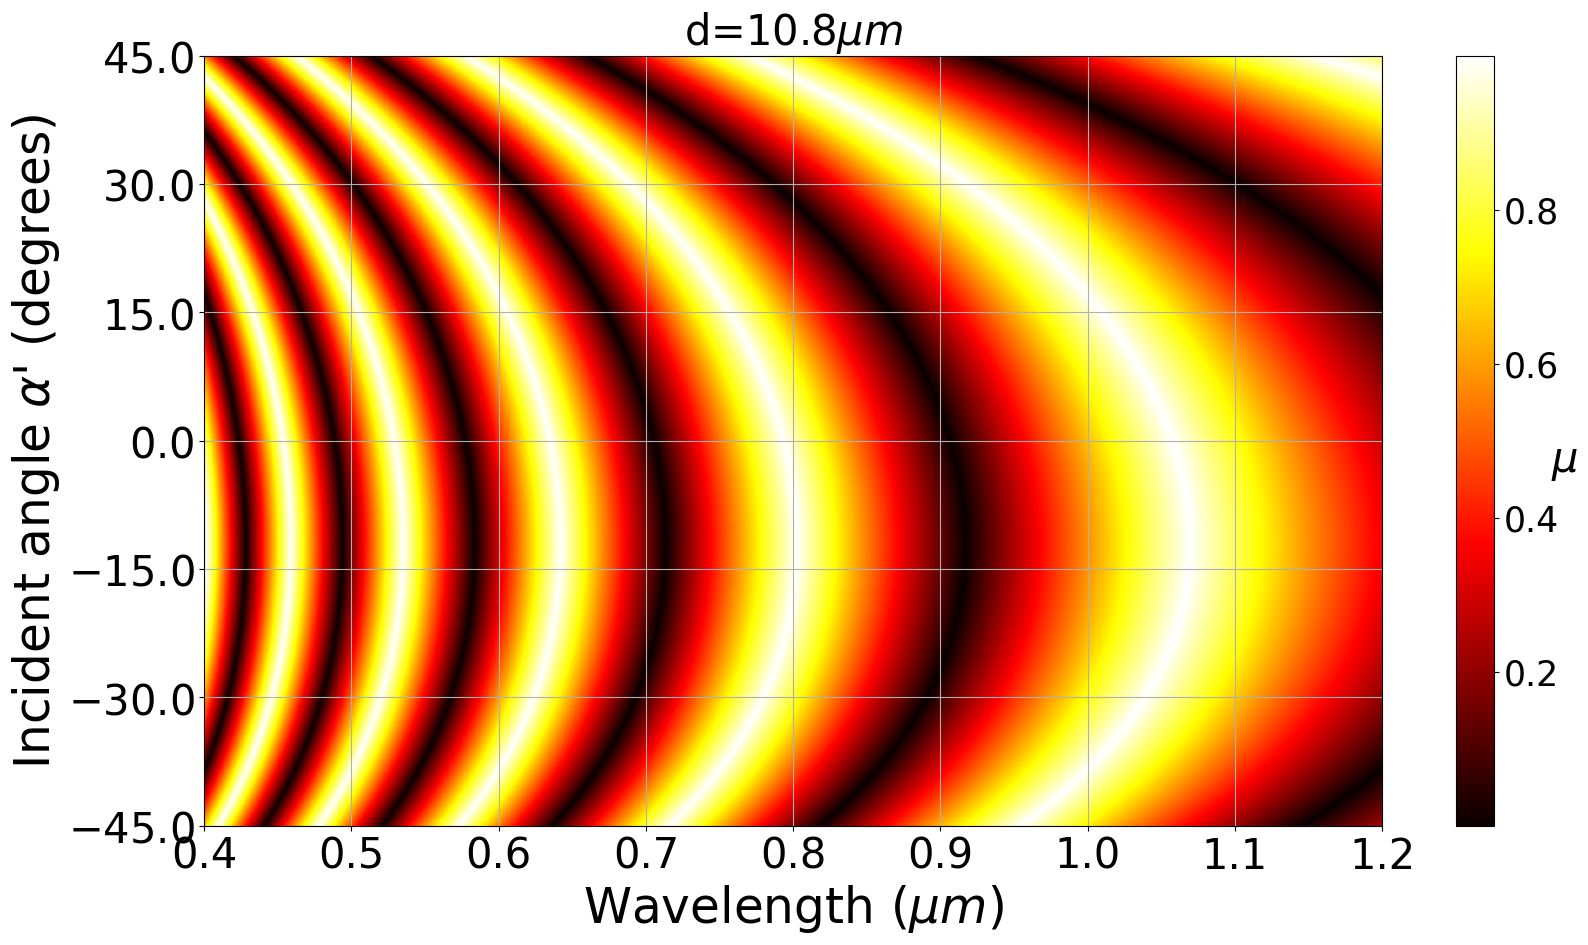

In [8]:
def show_mu_2d(d, theta):
    lambda_vec = np.linspace(0.4,1.2,1000)
    alpha_vec = np.linspace(-np.pi/4,np.pi/4,300)
    alpha_1D_vec = np.arctan(np.tan(alpha_vec)/np.sqrt(2))

    L,A1D = np.meshgrid(lambda_vec,alpha_1D_vec)
    f_mu = lambda _lambda, alpha: np.abs(np.mod(2*get_p(d, theta, _lambda)(alpha),2)-1)

    C = np.fromiter((f_mu(l,a) for l,a in zip(L.flatten(),A1D.flatten())), float).reshape(L.shape)

    plt.figure()
    plt.imshow(C, extent=[lambda_vec[0],lambda_vec[-1],alpha_vec[0],alpha_vec[-1]], aspect='auto', cmap = 'hot')
    plt.grid(True)
    plt.xlabel(r'Wavelength ($\mu m$)', fontsize=35)
    plt.xticks(fontsize=30)
    plt.ylabel(r"Incident angle $\alpha$' (degrees)", fontsize=35)
    ticks_degrees = np.linspace(-45,45,7)
    ticks_radians = ticks_degrees/180*np.pi
    plt.yticks(ticks_radians, [r'$'+str(t)+'$' for t in ticks_degrees], fontsize=30)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=25)
    cb.set_label(rotation = 0, label=r'$\mu$',size=30,weight='bold')
    plt.title(r'd=$%.1f\mu m$' % (d),fontsize = 30)
    plt.savefig(f'mu_2d_{d}.svg')

d = 7.6
show_mu_2d(d, theta)
d2 = 10.8
show_mu_2d(d2, theta)

## III. Simulation of the 2D far field pattern 

In [9]:
## A full numerical simulation of the Fourier plane for an all-on configuration

N = 30 # number of mirrors in each direction
g = 0#1.1 # gap between pixels in micron
res = 10 # pixels per mirror (for numerical calculation)
Nx = N*res

filling_fraction = d**2/(d+g)**2*100
print(f'filling fraction = {filling_fraction:.1f}%')

filling fraction = 100.0%


Text(0.5, 1.0, 'Energy efficiency = 82.27%')

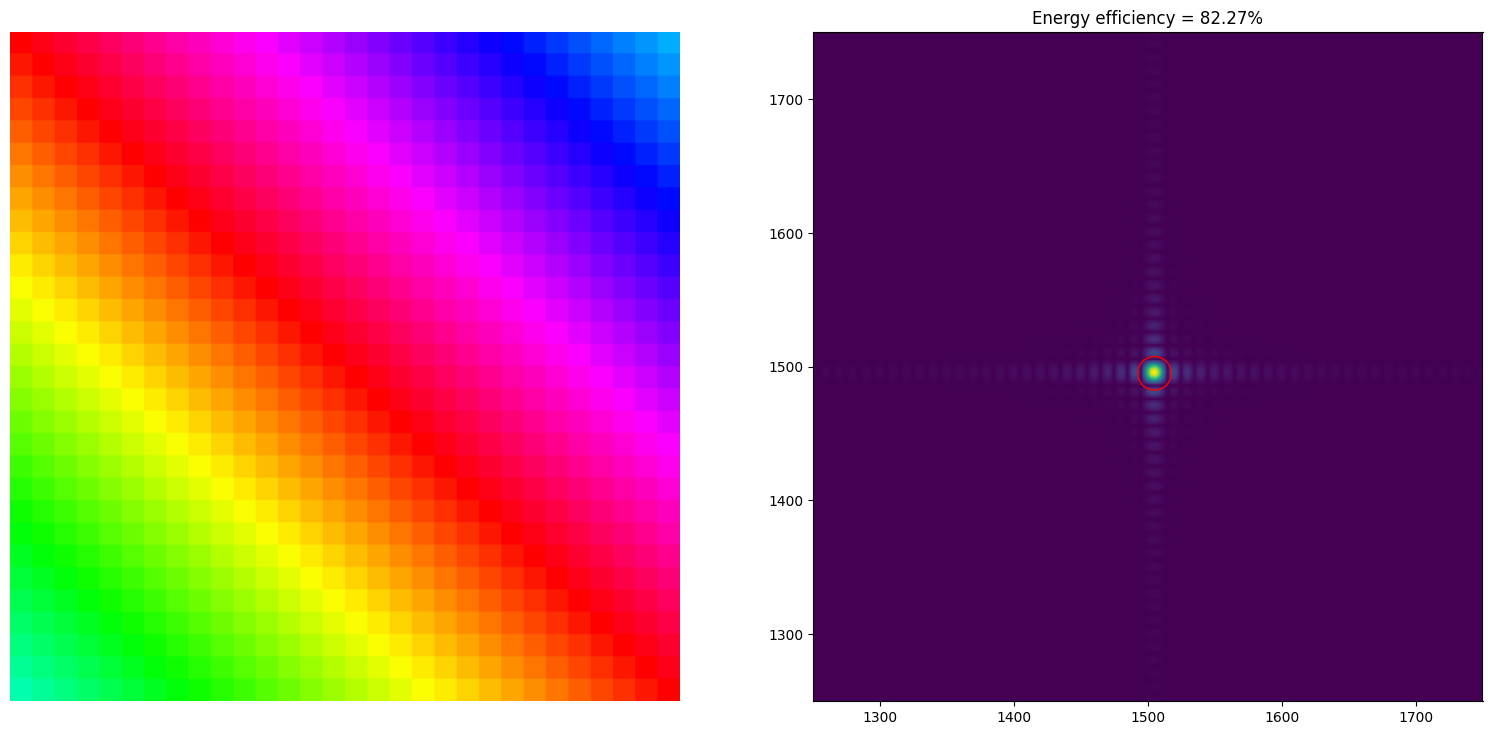

In [15]:
d = 10.8
theta = theta
_lambda = 0.633
alpha =  alpha1


def get_complex_field_on_DMD(d, theta, _lambda, alpha):
    beta = -alpha +2*theta # reflection angle
    alpha_1D = np.arctan(np.tan(alpha)/np.sqrt(2))
    theta_1D = np.arctan(np.tan(theta)/np.sqrt(2))
    beta_1D = 2*theta_1D-alpha_1D

    image_prefix = f'blazing_angle_d{d:.1f}_theta{theta*180/np.pi:.1f}_lambda{_lambda:.1f}_alpha{alpha*180/np.pi:.1f}'

    ## Pixelate image function
    f = np.ones([N,N]) # all-on configuration
    ## Phase slope due to incident and reflection angle
    X,Y = np.meshgrid(np.arange(N),np.arange(N))
    phi = np.exp((X-Y)*complex(0,1)*2*np.pi/_lambda*d*(np.sin(alpha_1D)+np.sin(beta_1D)))
    ## cell unit
    Cell = np.zeros([res,res])
    gpix = int(np.round(g/(2.*d)*res))
    x,y = np.meshgrid(np.arange(res),np.arange(res))
    Mask_cell = np.zeros([res,res])
    Mask_cell[gpix:res-gpix,gpix:res-gpix] = 1
    Cell = Mask_cell
    ## Mirror image
    MI = np.zeros([Nx,Nx],dtype='complex')
    for i in range(N):
        for j in range(N):
            MI[i*res:(i+1)*res,j*res:(j+1)*res]= f[i,j]*phi[i,j]*Cell
    return MI


def get_far_field(DMD_field, coeff = 10):
    ## In the Fourier plane
    
    FP = np.fft.fftshift(np.fft.fft2(DMD_field,s=[coeff*Nx,coeff*Nx]))
    return FP

def get_efficiency_in_FF(FF, mask_diameter = 15):
    max_pos = np.argmax(np.abs(FF))
    # index unwrap
    max_pos = np.unravel_index(max_pos, FF.shape)
    np.abs(FF)[max_pos]
    X,Y = np.meshgrid(np.arange(FF.shape[0]),np.arange(FF.shape[1]))
    X -= max_pos[1]
    Y -= max_pos[0]
    R = np.sqrt(X**2+Y**2)
    disk_mask = (R<=mask_diameter/2).astype(int)

    Energy_efficiency = np.sum(np.abs(FF)**2*disk_mask)/np.sum(np.abs(FF)**2)
    return np.array(max_pos), disk_mask, Energy_efficiency

DMD_field = get_complex_field_on_DMD(d, theta, _lambda, alpha)
FF = get_far_field(DMD_field)
mask_diameter = 25
max_pos, disk_mask, Energy_efficiency = get_efficiency_in_FF(FF, mask_diameter)



plt.figure()
plt.subplot(121)
plt.imshow(colorize(DMD_field))   
plt.axis('off')
plt.subplot(122)
plt.imshow(np.abs(FF))   
circle = plt.Circle((max_pos[1], max_pos[0]), radius=mask_diameter/2, color='red', fill=False)
plt.gca().add_patch(circle)
plt.xlim([1250, 1750])
plt.ylim([1250, 1750])
plt.title(f'Energy efficiency = {100*Energy_efficiency:.2f}%')

# plt.axis('off')

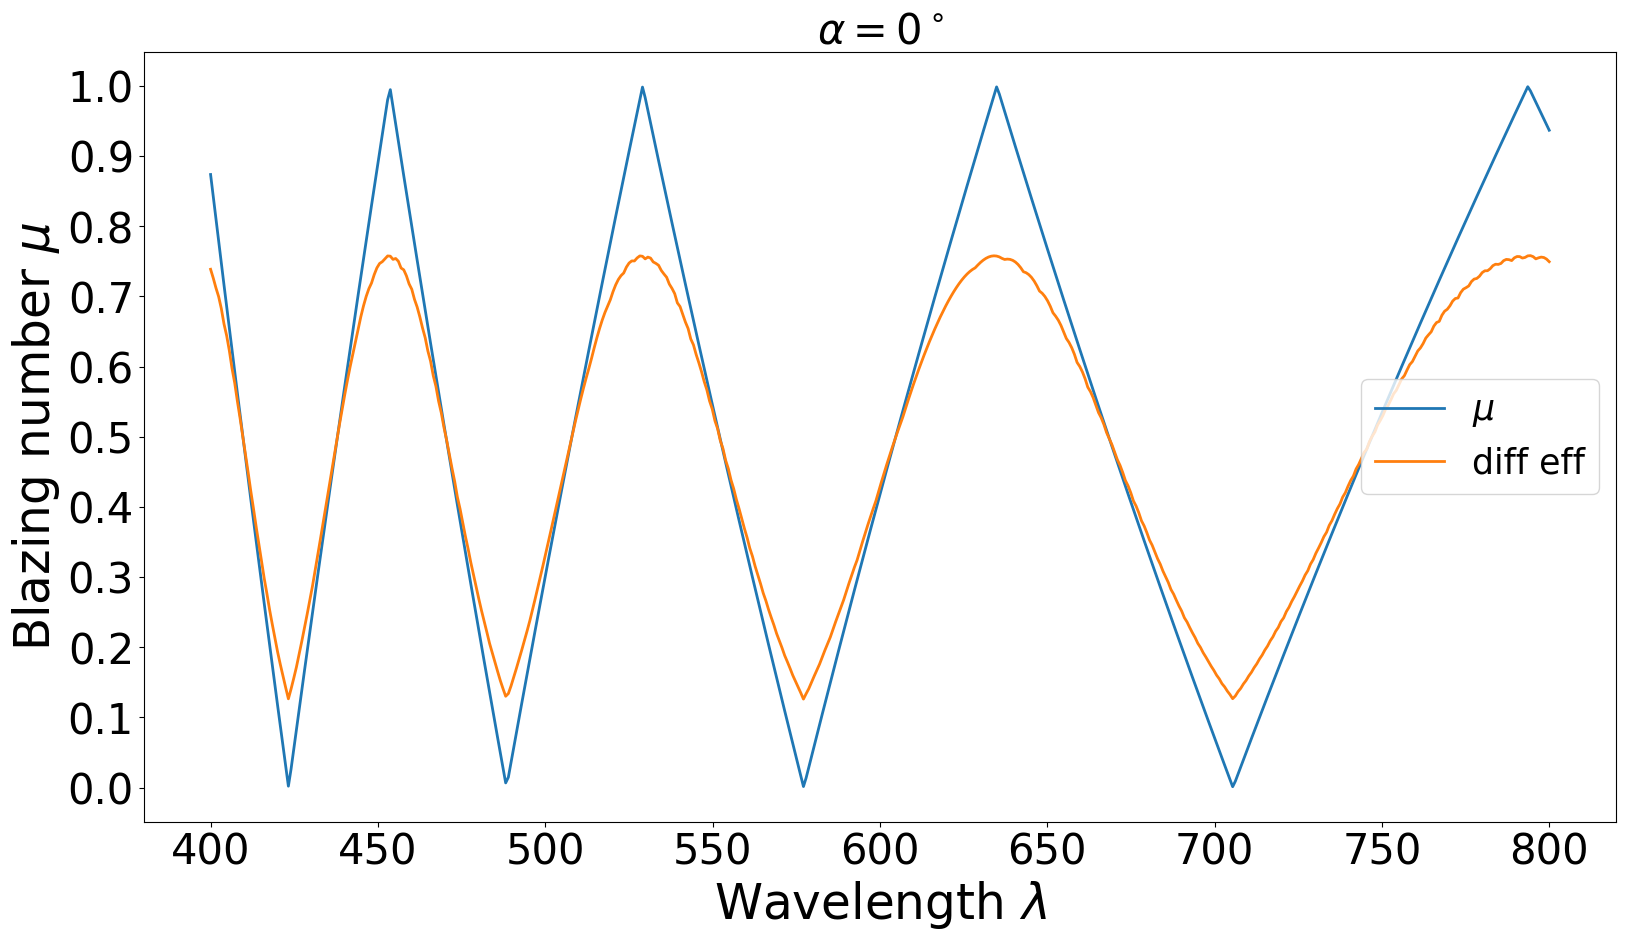

In [16]:
def get_eff(d, theta, _lambda, alpha):
    DMD_field = get_complex_field_on_DMD(d, theta, _lambda, alpha)
    FF = get_far_field(DMD_field)
    return  get_efficiency_in_FF(FF, mask_diameter = 15)[2]

lambda_vec = np.linspace(0.4,0.8,500)
f_mu = lambda _lambda: np.abs(np.mod(2*get_p(d, theta, _lambda)(alpha),2)-1)


mu_vec = np.fromiter((f_mu(l) for l in lambda_vec), float)
eff_vec = [
    get_eff(d, theta, l, alpha) for l in lambda_vec
]


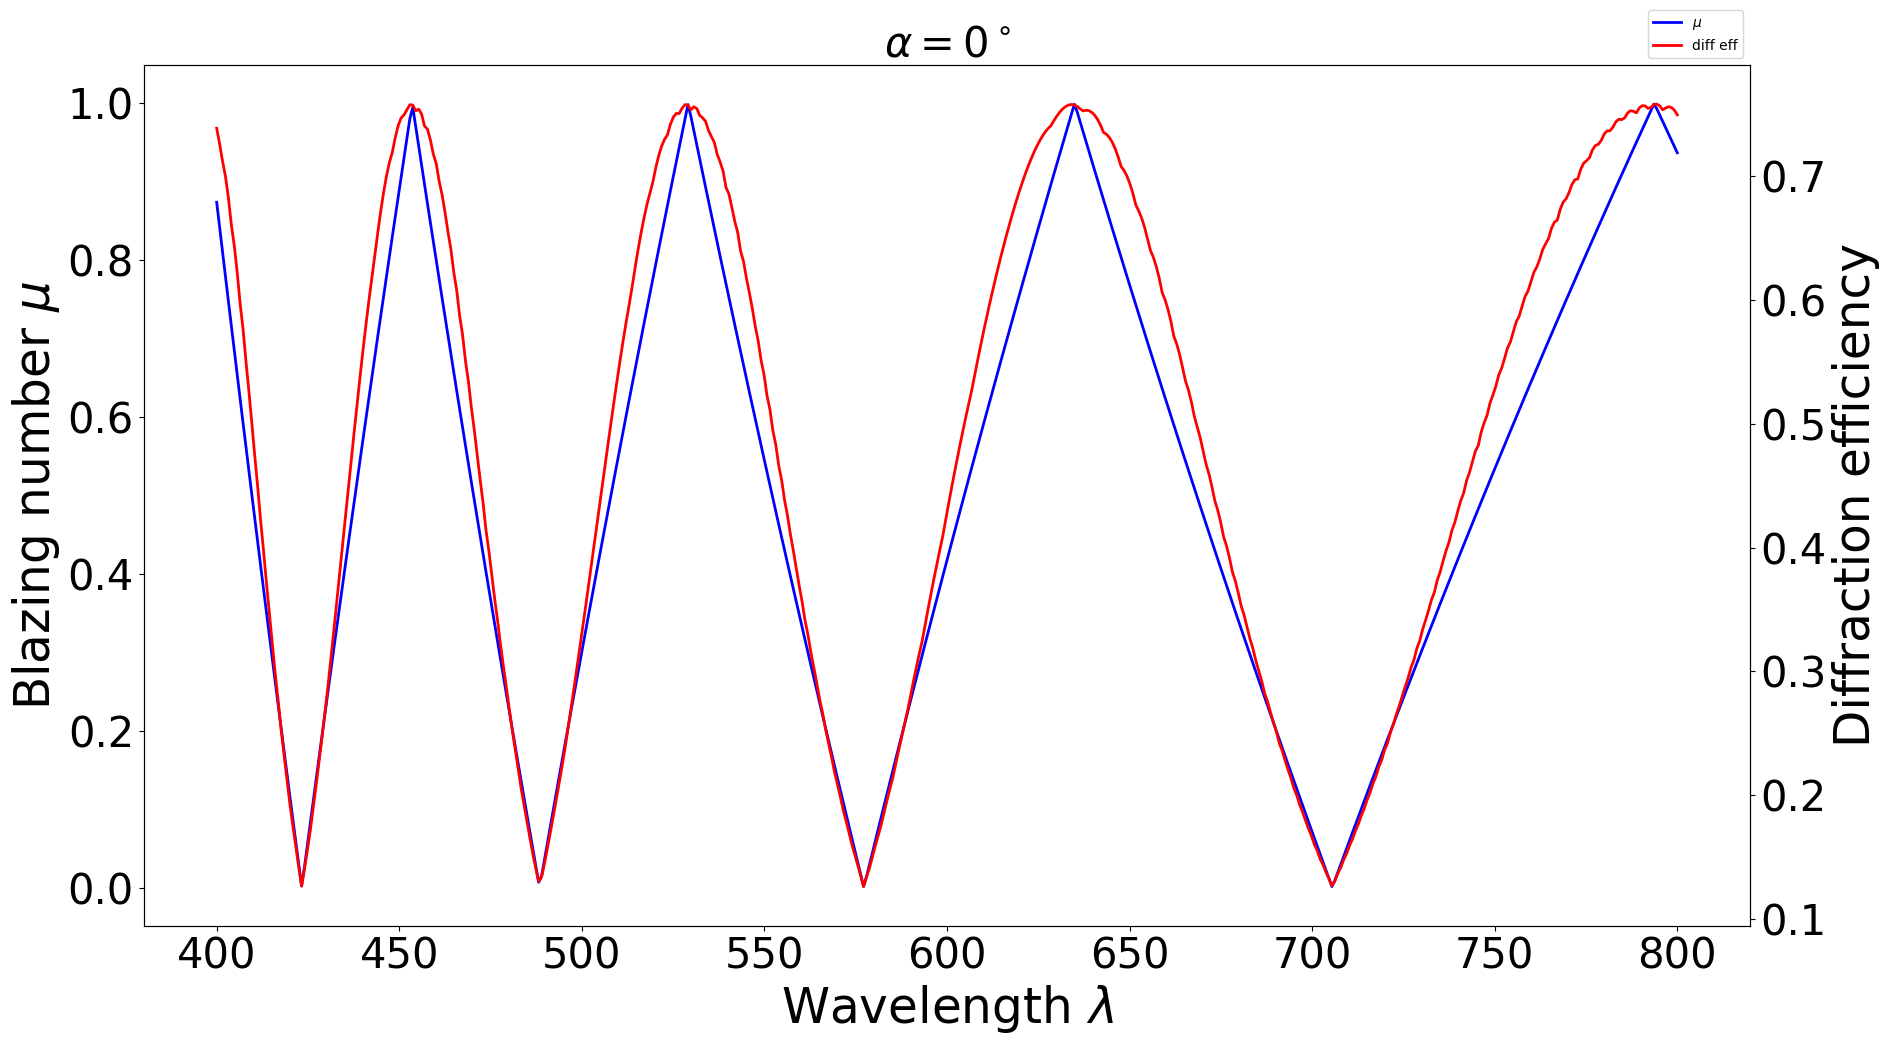

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(lambda_vec*1e3, mu_vec, linewidth=2, label=rf'$\mu$', color='b')
ax1.set_xlabel(r'Wavelength $\lambda$', fontsize = 35)
ax1.set_ylabel(r'Blazing number $\mu$', fontsize = 35)
ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

eff_vec = np.array(eff_vec)
# Create the second set of axes sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(lambda_vec*1e3, eff_vec, linewidth=2, label='diff eff', color='r')
ax2.set_ylabel('Diffraction efficiency', fontsize = 35)
ax2.tick_params(axis='y', labelsize=30)

# Add grid and legends
fig.tight_layout()
fig.legend(loc="lower right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)


# plt.xticks(fontsize = 30)
# plt.yticks(np.arange(0,max_val+0.05,0.1),fontsize = 30)
plt.title(r'$\alpha =' + str(alpha) + '^\circ$' ,fontsize = 30)

plt.xlabel(r'Wavelength $\lambda$', fontsize = 35)
# plt.legend(fontsize = 25,loc='lower right')
image_prefix = f'blazing_angle_d{d:.1f}_alpha{_lambda:.1f}'
plt.savefig(image_prefix+'_mu_vs_diffeff.svg', dpi = 300)

### III.2 Show diffractopm patterns

In [56]:
def show_2d(d, theta, _lambda, alpha):

    image_prefix = f'blazing_angle_d{d:.1f}_theta{theta*180/np.pi:.1f}_lambda{_lambda:.1f}_alpha{alpha*180/np.pi:.1f}'
    
    DMD_field = get_complex_field_on_DMD(d, theta, _lambda, alpha)
    
    # plt.figure()
    # plt.imshow(np.real(MI),interpolation = 'None')
    ## In the Fourier plane
    
    coeff = 5
    FP = get_far_field(DMD_field, coeff = coeff)
    ROIsize = 500
    ROI = 1
    plt.figure()
    plt.imshow((np.abs(FP[coeff*Nx//2-ROIsize//2:coeff*Nx//2+ROIsize//2,coeff*Nx//2-ROIsize//2:coeff*Nx//2+ROIsize//2]))**2,interpolation = 'None')
    plt.clim([0,(np.max(np.abs(FP)**2))/1.5])
    plt.scatter(ROIsize//2, ROIsize//2, s=500, edgecolors='red',alpha = 0.5,c='yellow',linewidths= 3.,  marker='x')
    plt.axis('off')
    plt.title(r'$\alpha = %.0f$ degres' % (alpha*180/np.pi),fontsize = 30)
    plt.savefig(image_prefix + '_farfield.svg', dpi = 300)

/tmp/ipykernel_28257/131662548.py:18: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(ROIsize//2, ROIsize//2, s=500, edgecolors='red',alpha = 0.5,c='yellow',linewidths= 3.,  marker='x')


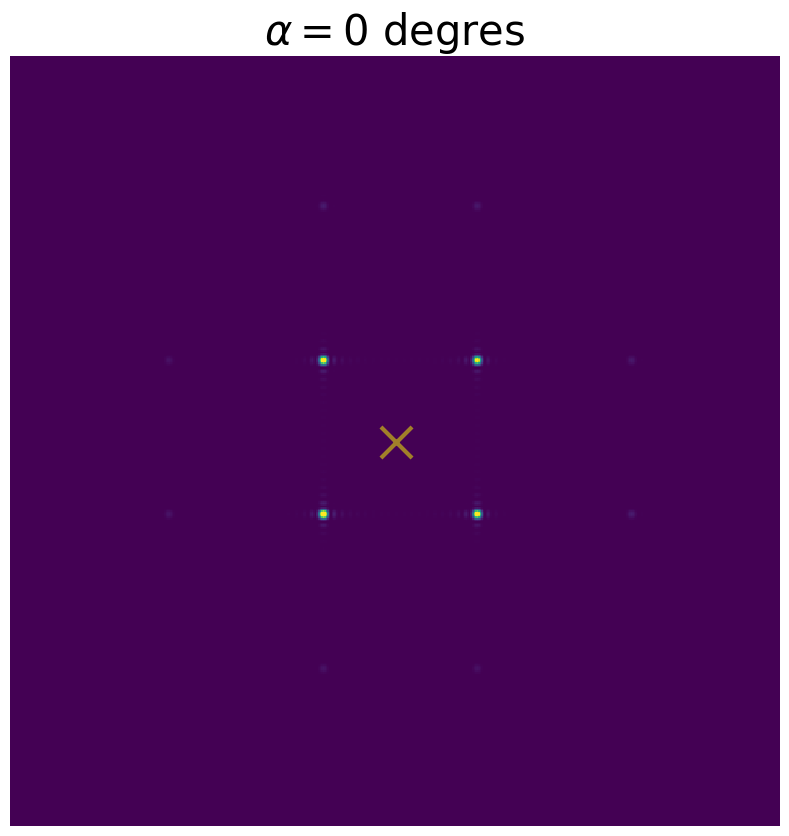

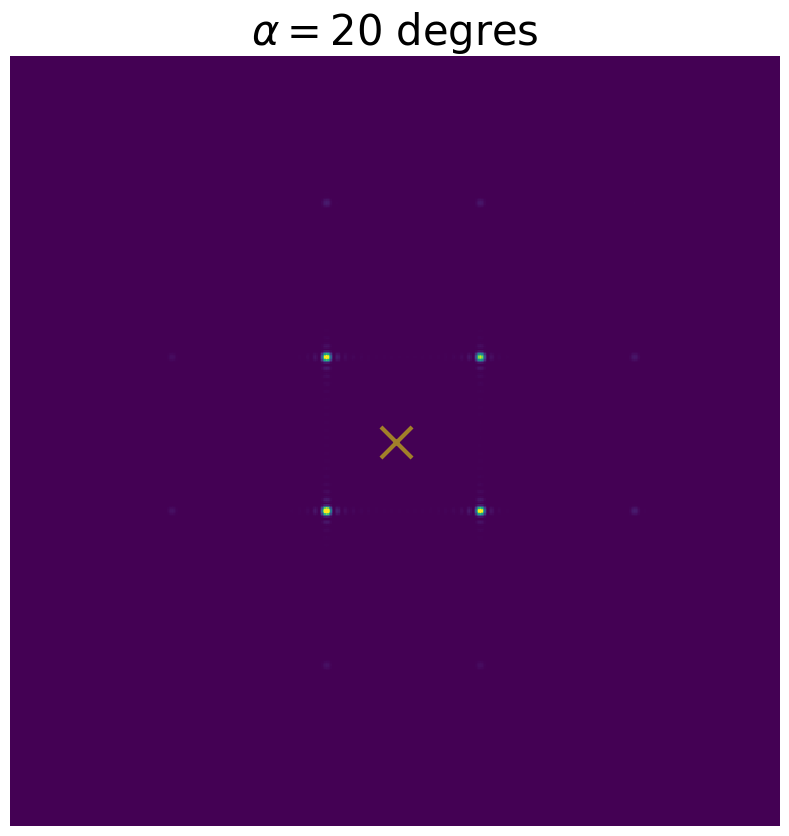

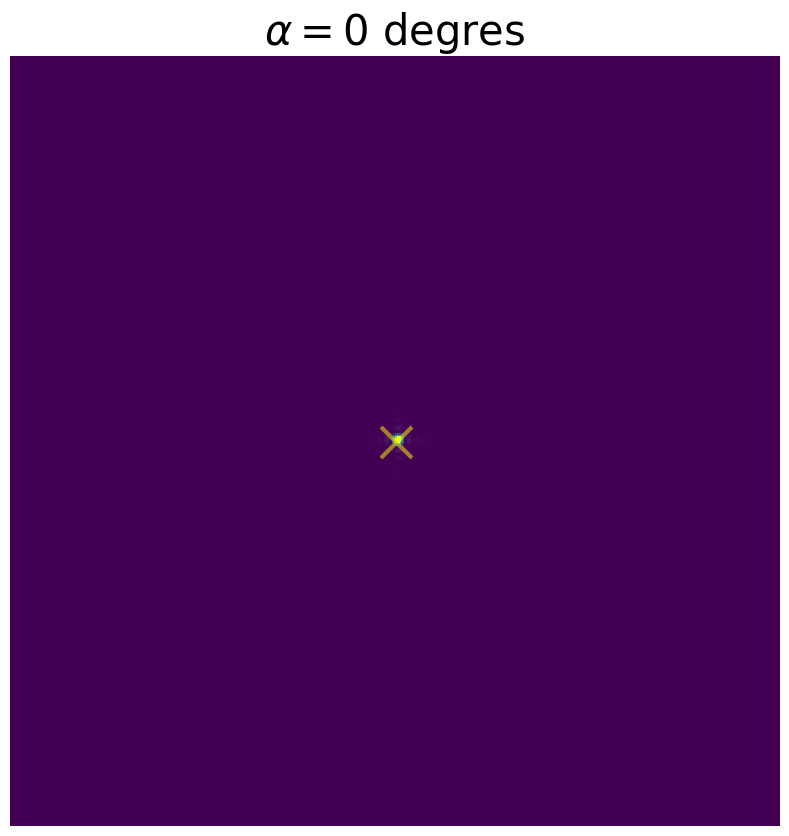

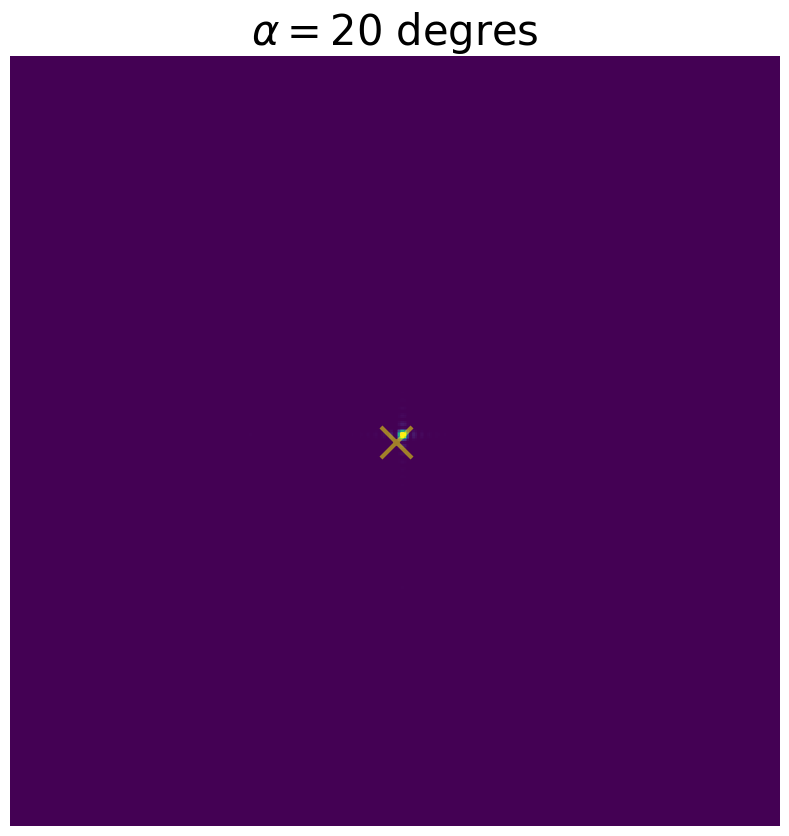

In [57]:
# alpha2 = 25./180*np.pi
show_2d(d = 7.6, theta = theta, _lambda = _lambda, alpha =  alpha1)
show_2d(d = 7.6, theta = theta, _lambda = _lambda, alpha =  alpha2)
show_2d(d = 10.8, theta = theta, _lambda = _lambda, alpha =  alpha1)
show_2d(d = 10.8, theta = theta, _lambda = _lambda, alpha =  alpha2)